In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models, pyLDAvis, seaborn, spacy
import multiprocessing, warnings, pickle, time, os, re
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## TV Commentary: TF-IDF Analysis
- #### 1. Preprocessing
    - 1.1. HTML Parsing
    - 1.2. Lowercase 
    - 1.3. Lemmization
    - 1.4. Remove Stopwords, Numbers and Special Characters
    - 1.5. More Cleaning
    <br/><br/>
- #### 2. TF-IDF Analysis
    - 2.1. Unigrams
    - 2.2. Bigrams

In [9]:
pd.set_option('display.max_colwidth', 1000)

# Import commentaries
path = os.path.join('dataset-football_commentary', 'dataset_converted', 'mentions_cleaned')
filename = 'mentions_cleaned_12.csv'
df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Position,Race,Reference,Teams,Year,Mention,Mention_Cleaned
0,Matt Leinart,QB,white,matt leinart,"['arizona_cardinals', 'chicago_bears']",2006,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', '<player>', 'all', 'you']",see lot see win lot s mike top
1,Matt Leinart,QB,white,matt leinart,"['arizona_cardinals', 'chicago_bears']",2006,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', 'all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers']",lot s mike top need do look simple number
2,Matt Leinart,QB,white,matt leinart,"['arizona_cardinals', 'chicago_bears']",2006,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'life', '372', 'as', 'a', 'starter', 'that', 's', 'what', 'this', 'man']",need do look simple number s life starter s man


In [12]:
df = df[['Player', 'Year', 'Race', 'Mention', 'Mention_Cleaned']]

for index, row in df.iterrows():
    if row['Race'] == 'white':
        df.at[index, 'Race'] = 'White'
    else:
        df.at[index, 'Race'] = 'Non-White'

df.head(3)


,Player,Year,Race,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', '<player>', 'all', 'you']",see lot see win lot s mike top
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', 'all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers']",lot s mike top need do look simple number
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'life', '372', 'as', 'a', 'starter', 'that', 's', 'what', 'this', 'man']",need do look simple number s life starter s man


## 1. Preprocessing
- 1.1. HTML Parsing
- 1.2. Lowercase 
- 1.3. Lemmization
- 1.4. Remove Stopwords, Numbers and Special Characters
- 1.5. More Cleaning

In [14]:
nlp = spacy.load('en_core_web_sm')

def clean(text):
    return ' '.join([token.lemma_          # Lemmization
           for token in nlp(text.lower())  # Split sentences into lowercase words
           if token.pos_ in content])      # Keep only "content" words

content = {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}
df['Mention_Cleaned'] = df['Mention_Cleaned'].apply(clean)

df.head(3)

,Player,Year,Race,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', '<player>', 'all', 'you']",see lot see win lot mike top
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', 'all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers']",lot s mike top need look simple number
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'life', '372', 'as', 'a', 'starter', 'that', 's', 'what', 'this', 'man']",look simple number life starter man


In [18]:
# Remove empty reports
df = df[df['Mention_Cleaned'].notnull()]

# Make sure everything is a string
df['Mention_Cleaned'] = df['Mention_Cleaned'].apply(str)

In [19]:
# Save our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12.csv'

df.to_csv(os.path.join(path, filename), index=False)

## 2. TF-IDF Analysis
- 2.1. Unigrams
- 2.2. Bigrams

In [21]:
# Load our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12.csv'

df = pd.read_csv(os.path.join(path, filename))

# Split the dataset for white and non-white players
w = df[df['Race'] == 'White'].reset_index(drop=True)
nw = df[df['Race'] == 'Non-White'].reset_index(drop=True)
nw.head(3)

,Player,Year,Race,Mention,Mention_Cleaned
0,David Garrard,2006,Non-White,"['&gt;&gt;', 'after', 'the', 'colts', 'punt,', 'from', 'the', '6,', 'first', 'and', '10', 'for', 'and', 'jacksonville', 's', 'offense', '<player>', 'got', 'a', 'great', 'block', 'from', '<player>']",colt punt first jacksonville offense get great block
1,David Garrard,2006,Non-White,"['this', 'position', 'garrard,', 'first', 'and', '10', 'chased', 'by', '<player>', 'this', 'is', 'what', 'can', 'do', 'so', 'well,', 'and', 'he', 'is', 'knocked', 'out', 'of', 'bounds']",position garrard first chase so knock bind
2,David Garrard,2006,Non-White,"['backfield', 'with', '<player>', 'there', 's', 'a', 'block', 'by', '<player>', 'and', 'time', 'for', 'a', 'wobbly', 'pass', 'which', 'may', 'have', 'been', 'deflected', 'did', '<player>', 'get']",backfield block time wobbly pass deflect get


In [23]:
w_docs = w['Mention_Cleaned'].tolist()
nw_docs = nw['Mention_Cleaned'].tolist()

### 2.1. Unigram

In [46]:
# Set our parameters to filter out rare words (min_df) and the too common ones (max_df), we do not want to get flooded with non-informative content words (be, go, etc.)
min_df = 5
max_df = 100000

# TF-IDF and Count for unigrams 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df, sublinear_tf=True, use_idf=True)
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df)

In [54]:
# White players
X_count = count_vectorizer.fit_transform(w_docs)
X_tfidf = tfidf_vectorizer.fit_transform(w_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_w = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_w = df_w.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_w['relative_tf'] = df_w['tf'] * 100000 / df_w['tf'].sum()
df_w['relative_tfidf'] = df_w['tfidf'] * 100000 / df_w['tf'].sum()
df_w.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
2674,throw,3063,3.133001,619.106346,1674.429284,338.442636
1977,play,3022,3.128326,603.061014,1652.016094,329.671244
1087,game,2468,3.310002,524.344190,1349.164699,286.639656
1423,just,2425,3.347262,515.840878,1325.658182,281.991208
2971,yard,2266,3.427677,505.567519,1238.738739,276.375142


In [55]:
# Non-White players
X_count = count_vectorizer.fit_transform(nw_docs)
X_tfidf = tfidf_vectorizer.fit_transform(nw_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_nw = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_nw = df_nw.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_nw['relative_tf'] = df_nw['tf'] * 100000 / df_nw['tf'].sum()
df_nw['relative_tfidf'] = df_nw['tfidf'] * 100000 / df_nw['tf'].sum()
df_nw.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
1437,play,1736,3.099086,353.016879,1711.491443,348.033046
1957,throw,1639,3.203552,342.970018,1615.860872,338.128025
791,game,1460,3.287502,309.693595,1439.387964,305.321392
1638,run,1316,3.404069,298.264625,1297.420932,294.053775
2164,yard,1304,3.391533,294.308062,1285.590346,290.153070


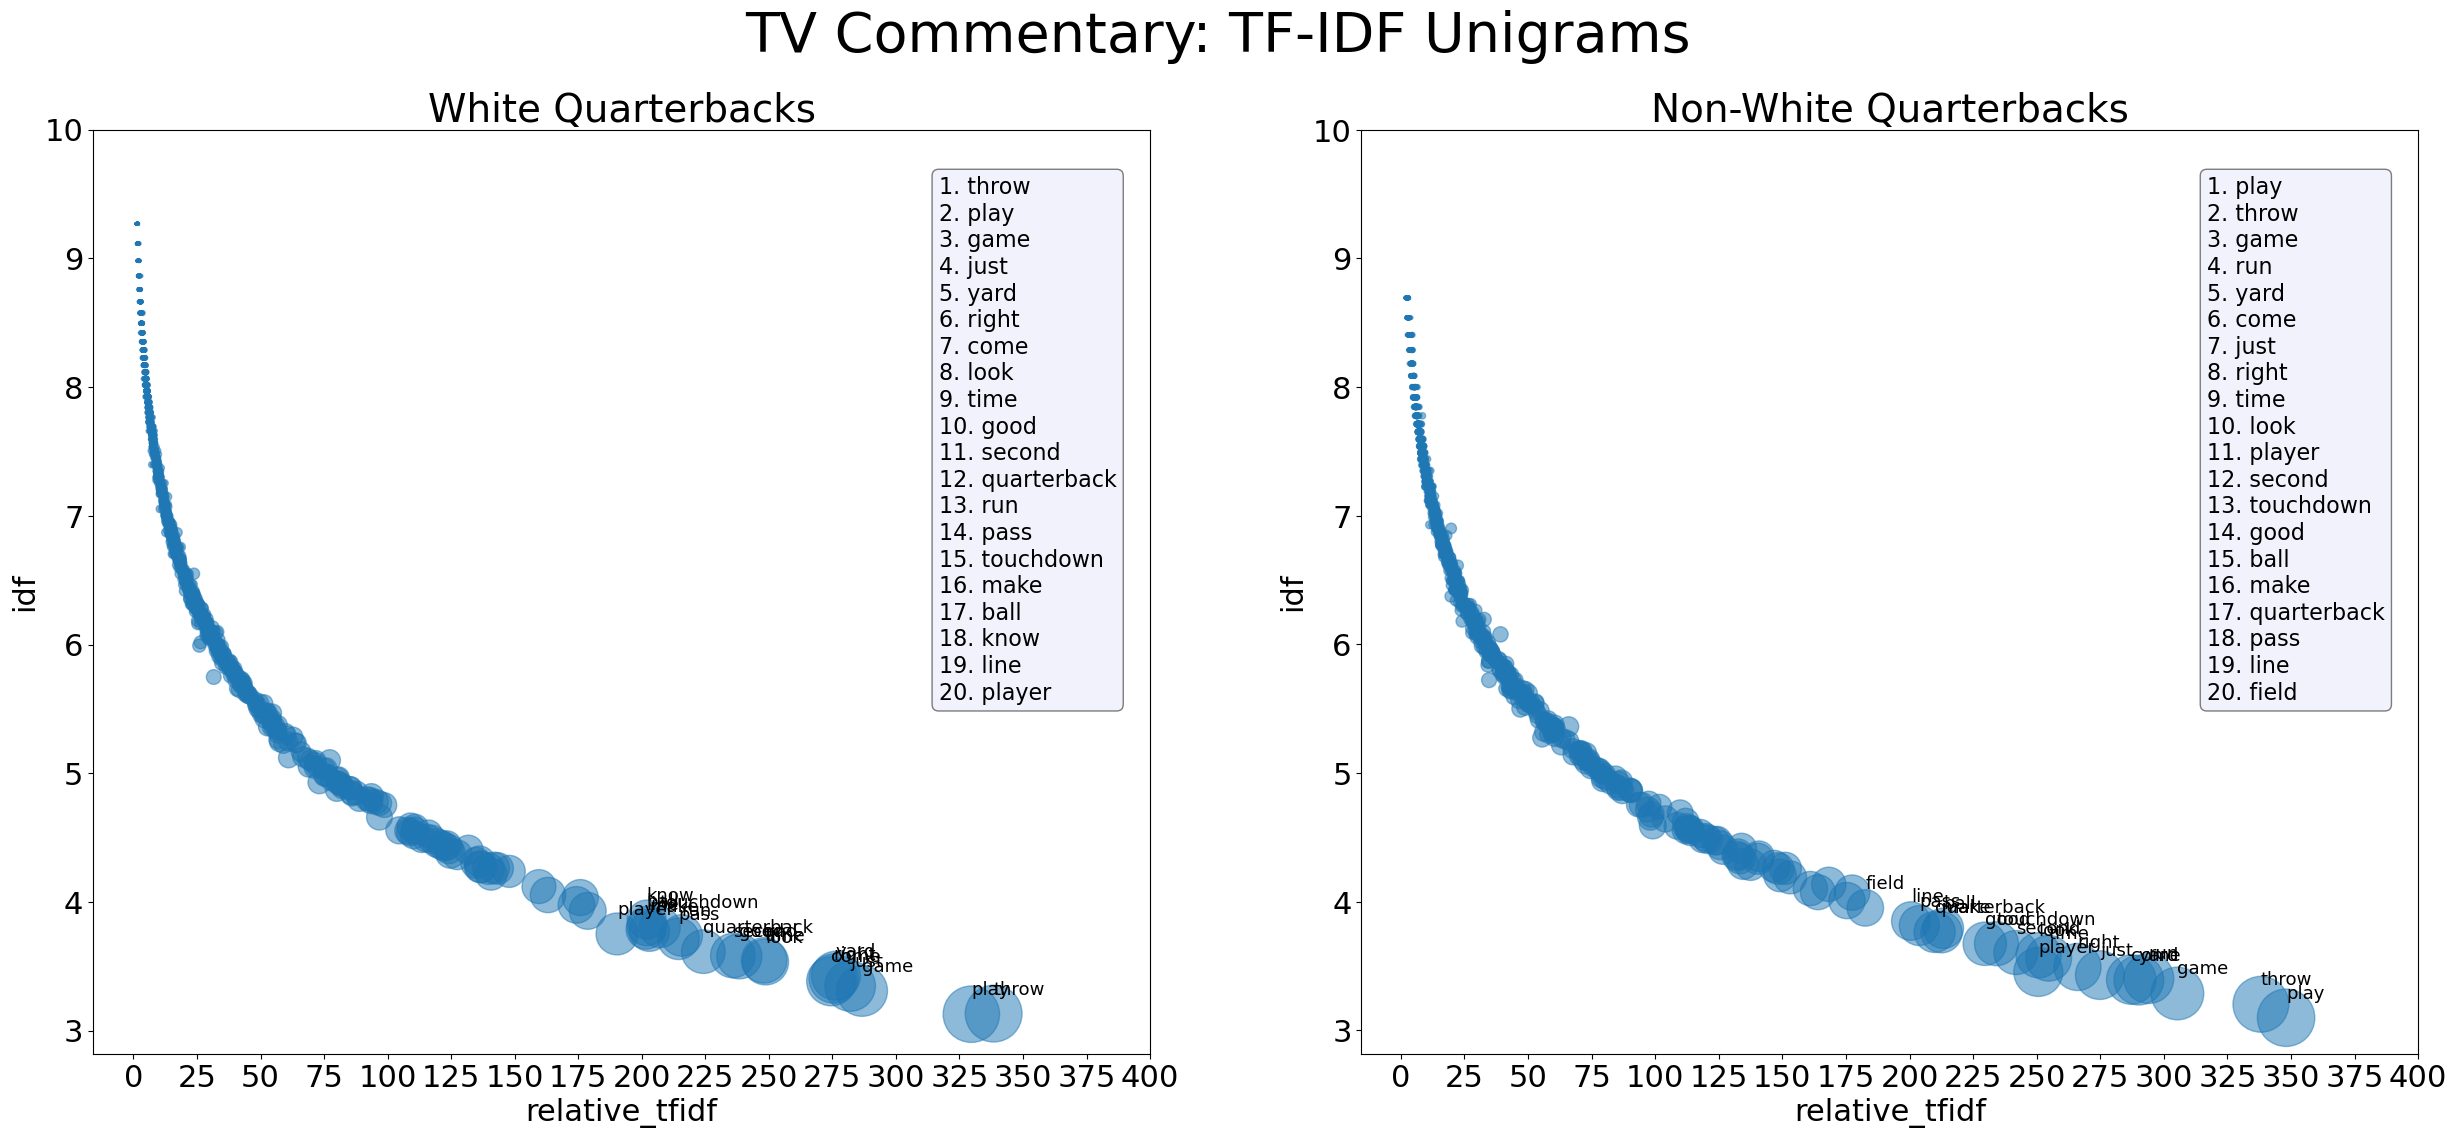

In [59]:
# Plot, with annotations for top 20

plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(1,2, figsize = (30,12))
top = 20
xticks = range(0, 401, 25)
yticks = range(3, 11)

ax = axs[0]
ax = df_w.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.5, edgecolor = 'tab:blue', xticks=xticks, yticks=yticks)

text = []
t = 1
for i in list(df_w.index[:top]):
    ax.annotate(df_w.word[i], (df_w.relative_tfidf[i], df_w.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_w.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('White Quarterbacks', fontsize=28)

ax = axs[1]
ax = df_nw.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.5, edgecolor = 'tab:blue', xticks=xticks, yticks=yticks)

text = []
t = 1
for i in list(df_nw.index[:top]):
    ax.annotate(df_nw.word[i], (df_nw.relative_tfidf[i], df_nw.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_nw.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('Non-White Quarterbacks', fontsize=28)

fig.suptitle("TV Commentary: TF-IDF Unigrams", fontsize=40)
plt.show()

### 2.2. Bigrams

In [60]:
# Set our parameters to filter out rare words (min_df) and the too common ones (max_df), we do not want to get flooded with non-informative content words (be, go, etc.)
min_df = 3
max_df = 100000

# TF-IDF and Count for bigrams 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df, sublinear_tf=True, use_idf=True)
count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df)

In [61]:
# White players
X_count = count_vectorizer.fit_transform(w_docs)
X_tfidf = tfidf_vectorizer.fit_transform(w_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_w = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_w = df_w.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_w['relative_tf'] = df_w['tf'] * 100000 / df_w['tf'].sum()
df_w['relative_tfidf'] = df_w['tfidf'] * 100000 / df_w['tf'].sum()
df_w.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
9840,yard line,453,4.951799,170.952626,657.388730,248.084613
4405,little bit,371,5.161149,139.549936,538.391212,202.513367
9204,touchdown pass,371,5.166644,127.577782,538.391212,185.139505
1981,end zone,260,5.519783,104.694923,377.309205,151.932147
7623,second half,216,5.699755,85.564803,313.456878,124.170722


In [62]:
# Non-White players
X_count = count_vectorizer.fit_transform(nw_docs)
X_tfidf = tfidf_vectorizer.fit_transform(nw_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_nw = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_nw = df_nw.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_nw['relative_tf'] = df_nw['tf'] * 100000 / df_nw['tf'].sum()
df_nw['relative_tfidf'] = df_nw['tfidf'] * 100000 / df_nw['tf'].sum()
df_nw.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
2418,little bit,215,5.123645,97.380360,626.913544,283.949148
5457,yard line,229,5.051215,96.987639,667.735822,282.804022
1076,end zone,183,5.303154,81.754653,533.605482,238.386507
5098,touchdown pass,197,5.211938,74.622262,574.427759,217.589333
4909,tight end,128,5.656623,56.417561,373.232250,164.506667


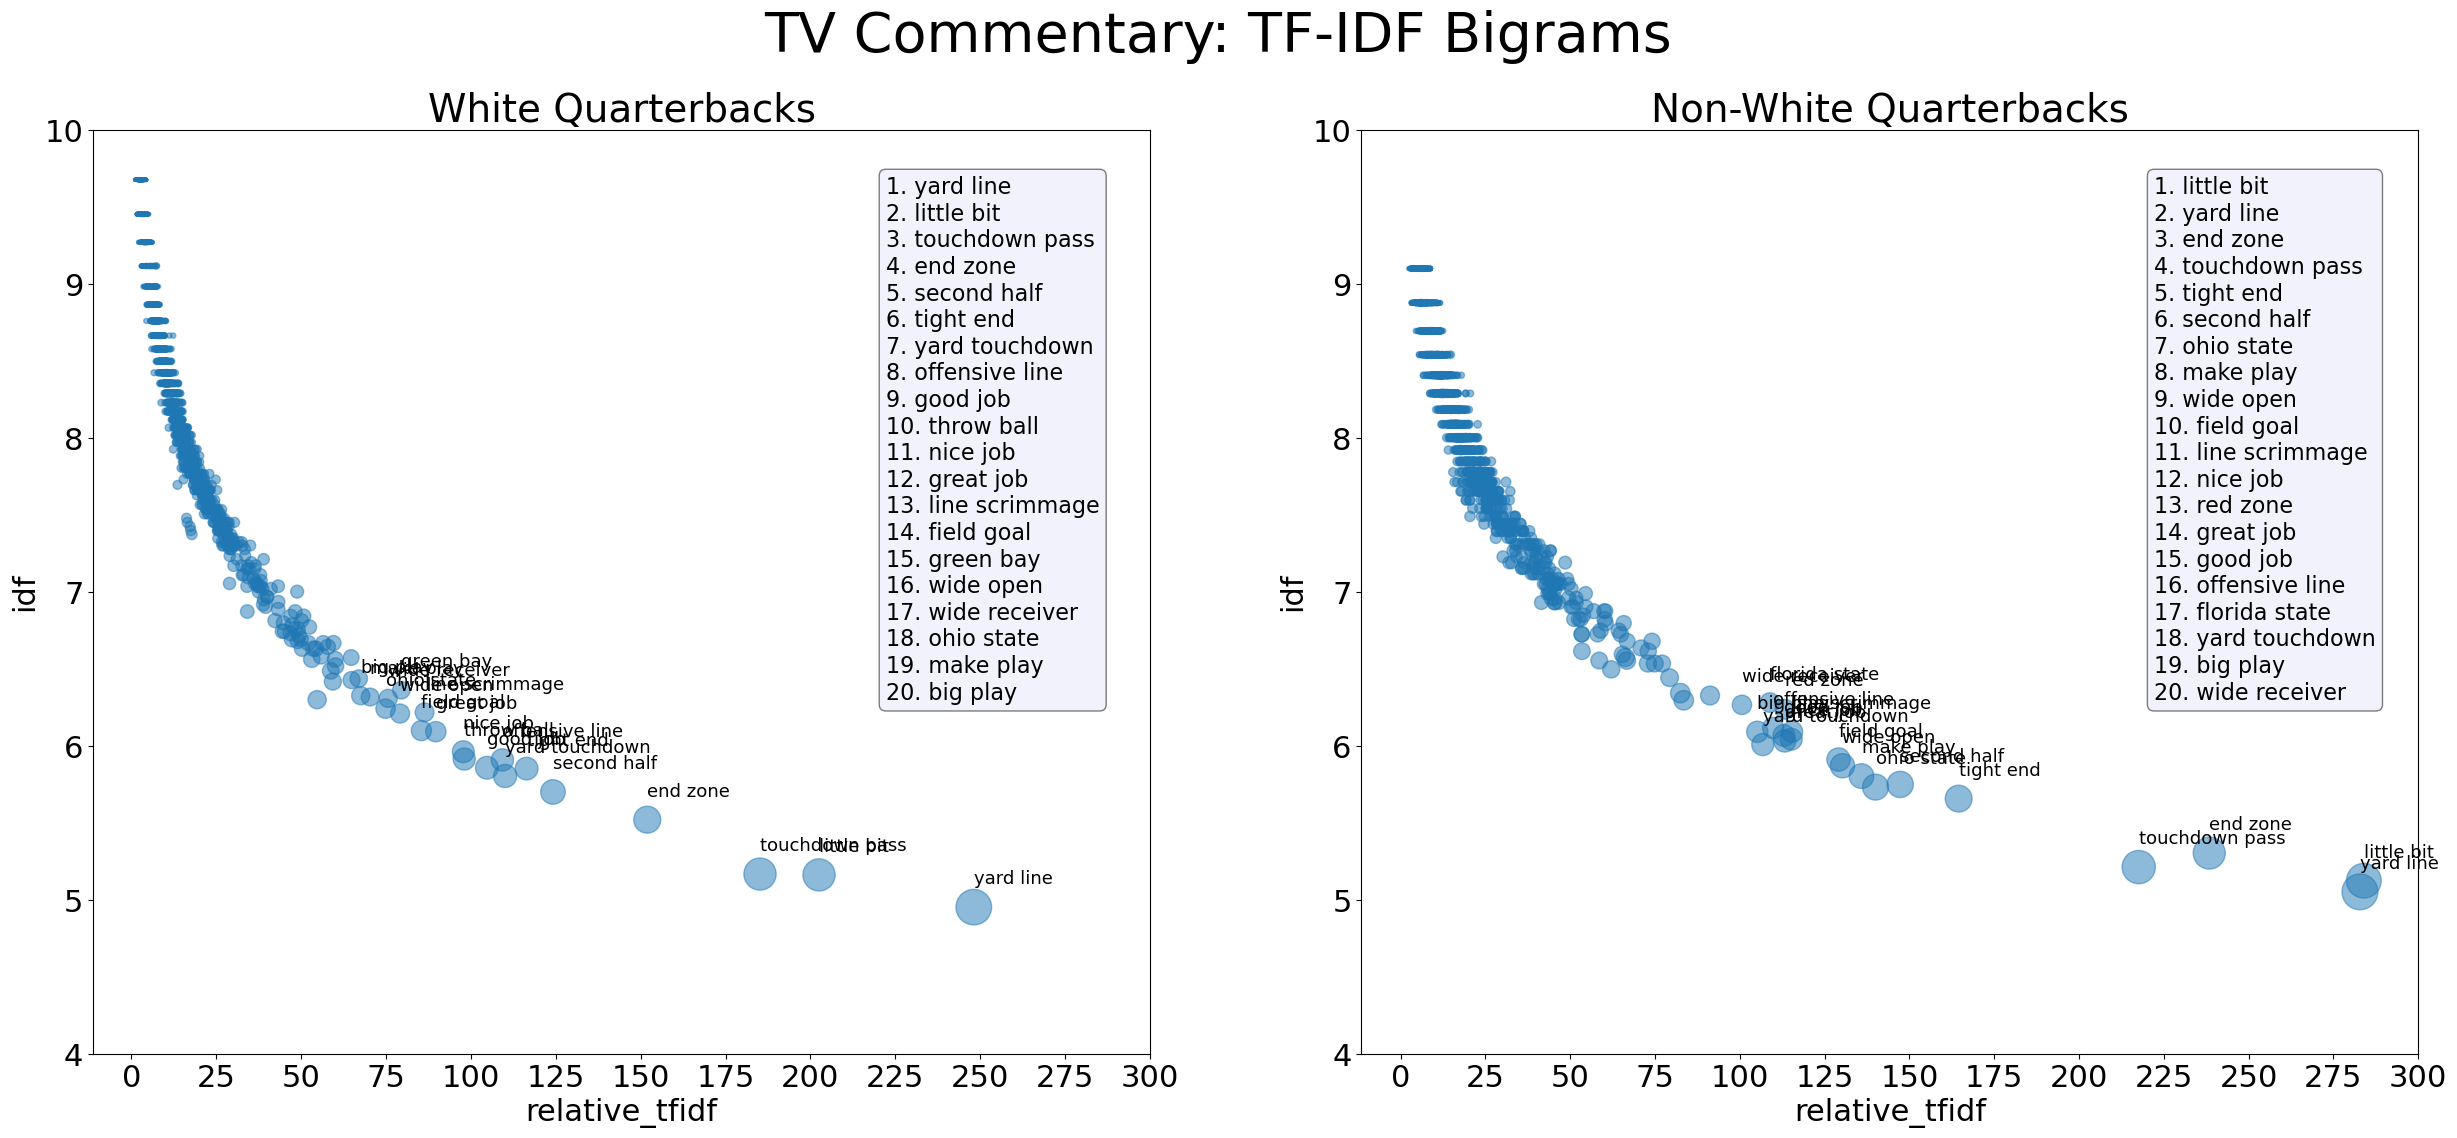

In [66]:
# Plot, with annotations for top 20

plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(1,2, figsize = (30,12))
top = 20
xticks = range(0, 301, 25)
yticks = range(4, 11)

ax = axs[0]
ax = df_w.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.5, edgecolor = 'tab:blue', xticks=xticks, yticks=yticks)

text = []
t = 1
for i in list(df_w.index[:top]):
    ax.annotate(df_w.word[i], (df_w.relative_tfidf[i], df_w.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_w.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('White Quarterbacks', fontsize=28)

ax = axs[1]
ax = df_nw.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.5, edgecolor = 'tab:blue', xticks=xticks, yticks=yticks)

text = []
t = 1
for i in list(df_nw.index[:top]):
    ax.annotate(df_nw.word[i], (df_nw.relative_tfidf[i], df_nw.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_nw.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('Non-White Quarterbacks', fontsize=28)

fig.suptitle("TV Commentary: TF-IDF Bigrams", fontsize=40)
plt.show()